<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Visualizations" data-toc-modified-id="Visualizations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualizations</a></span><ul class="toc-item"><li><span><a href="#Using-Mayavi" data-toc-modified-id="Using-Mayavi-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Using Mayavi</a></span></li><li><span><a href="#Using-Matplotlib" data-toc-modified-id="Using-Matplotlib-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Using Matplotlib</a></span></li></ul></li><li><span><a href="#Data-Overview" data-toc-modified-id="Data-Overview-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Overview</a></span></li><li><span><a href="#Backup" data-toc-modified-id="Backup-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Backup</a></span><ul class="toc-item"><li><span><a href="#Create-PCD-Files" data-toc-modified-id="Create-PCD-Files-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Create PCD Files</a></span></li><li><span><a href="#Visualizations" data-toc-modified-id="Visualizations-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visualizations</a></span><ul class="toc-item"><li><span><a href="#3D-Plot-using-matplotlib" data-toc-modified-id="3D-Plot-using-matplotlib-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>3D Plot using matplotlib</a></span></li><li><span><a href="#3D-Plot-using-pptk" data-toc-modified-id="3D-Plot-using-pptk-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>3D Plot using pptk</a></span></li></ul></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import string
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import time
import collections
import seaborn as sns 
# import pcl
import ipywidgets as widgets
from IPython.display import display
import h5py

from crowd_tracker_lidar3d.loader import load_data_to_dataframe
from crowd_tracker_lidar3d.plot_tools import plot_pointcloud3d, draw_point_cloud, show_projections
from crowd_tracker_lidar3d.preprocessing import rotate_pcl, df_apply_rot, return_ground_points, \
                                                remove_ground_points, standardize_data, translate_height,\
                                                add_polar_coord, rotate_pcl
from crowd_tracker_lidar3d.cluster_utils import return_cluster_and_noise_points, plot_xy_cluster_results, \
                                                plot_3d_cluster_results
from crowd_tracker_lidar3d.hdf5_util import load_h5
import matplotlib.pyplot as plt 

In [3]:
# Helper Function to save plots 
def save_fig(fig, filename, extension='.pdf'):
    save_dir = os.getcwd()
    save_dir = os.path.join(save_dir, "../plots/") + str(filename) + extension
    fig.savefig(save_dir, bbox_inches='tight')  

## Load Data

In [4]:
os.getcwd()

'/home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/jupyter_nbs'

In [5]:
DATA_DIR = os.path.dirname(os.path.abspath(''))
DATA_DIR = os.path.join(DATA_DIR, "data/med/annotated_boundbox/")

In [6]:
print(DATA_DIR)

/home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/data/med/annotated_boundbox/


In [7]:
for folder in sorted(os.listdir(DATA_DIR)):
    print(folder)
    path = os.path.join(DATA_DIR, folder) 
    data_files = [str(f) for f in sorted(os.listdir(path)) if f.endswith('.h5')] 
    break

person166_1


In [8]:
f = os.path.join(path, 'frame100.h5')
print(f)

/home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/data/med/annotated_boundbox/person166_1/frame100.h5


In [9]:
data, bbox = load_h5(f)

In [10]:
bbox

array([1.6373289 , 0.48378003, 0.44720954, 0.6592187 , 0.31969118,
       0.38746938], dtype=float32)

In [11]:
centroid, h, w, l = bbox[0:3], bbox[3], bbox[4], bbox[5] 

## Visualizations

### Using Mayavi

In [ ]:
from mayavi import mlab

In [13]:
mlab.init_notebook()

Notebook initialized with ipy backend.


In [14]:
def draw_lidar_simple(pc, color=None):
    ''' Draw lidar points. simplest set up. '''
    fig = mlab.figure(figure=None, bgcolor=(0,0,0), fgcolor=None, engine=None, size=(1600, 1000))
    if color is None: 
        color = pc[:,2]
    #draw points
        # draw points
    mlab.points3d(
        pc[:, 0],
        pc[:, 1],
        pc[:, 2],
        color,
        color=None,
        mode="point",
        colormap="gnuplot",
        scale_factor=1,
        figure=fig,
    )
    #draw origin
    mlab.points3d(0, 0, 0, color=(1,1,1), mode='sphere', scale_factor=0.2)
    #draw axis
    axes=np.array([
        [2.,0.,0.,0.],
        [0.,2.,0.,0.],
        [0.,0.,2.,0.],
    ],dtype=np.float64)
    
    mlab.plot3d([0, axes[0,0]], [0, axes[0,1]], [0, axes[0,2]], color=(1,0,0), tube_radius=None, figure=fig)
    mlab.plot3d([0, axes[1,0]], [0, axes[1,1]], [0, axes[1,2]], color=(0,1,0), tube_radius=None, figure=fig)
    mlab.plot3d([0, axes[2,0]], [0, axes[2,1]], [0, axes[2,2]], color=(0,0,1), tube_radius=None, figure=fig)
    mlab.view(azimuth=180, elevation=70, focalpoint=[ 12.0909996 , -1.04700089, -2.03249991], distance=30.0, figure=fig)
    return fig

In [17]:
def calc_3d_box(bbox): 
    x, y, z, h, w, l = bbox[:6]
    box8 = np.array(
        [
            [
                x + w / 2,
                x + w / 2,
                x - w / 2,
                x - w / 2,
                x + w / 2,
                x + w / 2,
                x - w / 2,
                x - w / 2,
            ],
            [
                y - l / 2,
                y + l / 2,
                y + l / 2,
                y - l / 2,
                y - l / 2,
                y + l / 2,
                y + l / 2,
                y - l / 2,
            ],
            [
                z - h / 2,
                z - h / 2,
                z - h / 2,
                z - h / 2,
                z + h / 2,
                z + h / 2,
                z + h / 2,
                z + h / 2,
            ],
        ]
    )
    return box8.T

In [ ]:
def draw_gt_boxes3d(
    gt_boxes3d,
    fig,
    color=(1, 1, 1),
    line_width=1,
    draw_text=False,
    text_scale=(1, 1, 1),
    color_list=None,
    label=""
):
    """ Draw 3D bounding boxes
    Args:
        gt_boxes3d: numpy array (n,8,3) for XYZs of the box corners
        fig: mayavi figure handler
        color: RGB value tuple in range (0,1), box line color
        line_width: box line width
        draw_text: boolean, if true, write box indices beside boxes
        text_scale: three number tuple
        color_list: a list of RGB tuple, if not None, overwrite color.
    Returns:
        fig: updated fig
    """
    num = len(gt_boxes3d)
    for n in range(num):
        b = gt_boxes3d[n]
        if color_list is not None:
            color = color_list[n]
        if draw_text:
            mlab.text3d(
                b[4, 0],
                b[4, 1],
                b[4, 2],
                label,
                scale=text_scale,
                color=color,
                figure=fig,
            )
        for k in range(0, 4):
            # http://docs.enthought.com/mayavi/mayavi/auto/mlab_helper_functions.html
            i, j = k, (k + 1) % 4
            mlab.plot3d(
                [b[i, 0], b[j, 0]],
                [b[i, 1], b[j, 1]],
                [b[i, 2], b[j, 2]],
                color=color,
                tube_radius=None,
                line_width=line_width,
                figure=fig,
            )

            i, j = k + 4, (k + 1) % 4 + 4
            mlab.plot3d(
                [b[i, 0], b[j, 0]],
                [b[i, 1], b[j, 1]],
                [b[i, 2], b[j, 2]],
                color=color,
                tube_radius=None,
                line_width=line_width,
                figure=fig,
            )

            i, j = k, k + 4
            mlab.plot3d(
                [b[i, 0], b[j, 0]],
                [b[i, 1], b[j, 1]],
                [b[i, 2], b[j, 2]],
                color=color,
                tube_radius=None,
                line_width=line_width,
                figure=fig,
            )
    # mlab.show(1)
    # mlab.view(azimuth=180, elevation=70, focalpoint=[ 12.0909996 , -1.04700089, -2.03249991], distance=62.0, figure=fig)
    return fig

In [20]:
box8 = calc_3d_box(bbox)
print(box8)
print(box8.shape)
gt_box = np.reshape(box8, (-1,8,3))
print(gt_box)
print(gt_box.shape)

[[1.79717445 0.29004534 0.11760017]
 [1.79717445 0.67751472 0.11760017]
 [1.47748327 0.67751472 0.11760017]
 [1.47748327 0.29004534 0.11760017]
 [1.79717445 0.29004534 0.7768189 ]
 [1.79717445 0.67751472 0.7768189 ]
 [1.47748327 0.67751472 0.7768189 ]
 [1.47748327 0.29004534 0.7768189 ]]
(8, 3)
[[[1.79717445 0.29004534 0.11760017]
  [1.79717445 0.67751472 0.11760017]
  [1.47748327 0.67751472 0.11760017]
  [1.47748327 0.29004534 0.11760017]
  [1.79717445 0.29004534 0.7768189 ]
  [1.79717445 0.67751472 0.7768189 ]
  [1.47748327 0.67751472 0.7768189 ]
  [1.47748327 0.29004534 0.7768189 ]]]
(1, 8, 3)


In [15]:
fig = draw_lidar_simple(data)

In [16]:
fig

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06@\x00\x00\x03\xe8\x08\x02\x00\x00\x00\t\x19\xa5\x…

In [21]:
f = draw_gt_boxes3d(gt_box, fig)

### Using Matplotlib

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

axes_limits = [
    [-5, 20], # X axis range
    [-10, 10], # Y axis range
    [-2, 4]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def display_frame_statistics(dataset, gt_boxes3d):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.
    
    Parameters
    ----------
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    frame           : Absolute number of the frame.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    """

    point_size = 0.2

    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(dataset[:, axes]), s=point_size, c=dataset[:, 3], cmap='viridis')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
#         User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
        
        num = len(gt_boxes3d)
        for n in range(num):
            b = gt_boxes3d[n].T
            draw_box(ax, b, axes=axes, color='g')
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-5,20))
    plt.show()
    
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
    draw_point_cloud(
        ax3[0], 
        'Velodyne scan, XZ projection (Y = 0)', 
        axes=[0, 2] # X and Z axes
    )
    draw_point_cloud(
        ax3[1], 
        'Velodyne scan, XY projection (Z = 0)', 
        axes=[0, 1] # X and Y axes
    )
    draw_point_cloud(
        ax3[2], 
        'Velodyne scan, YZ projection (X = 0)', 
        axes=[1, 2] # Y and Z axes
    )
    plt.show()


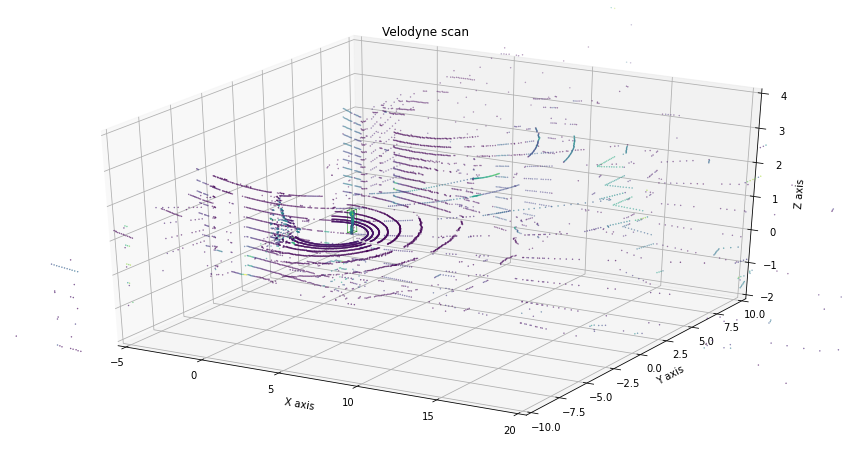

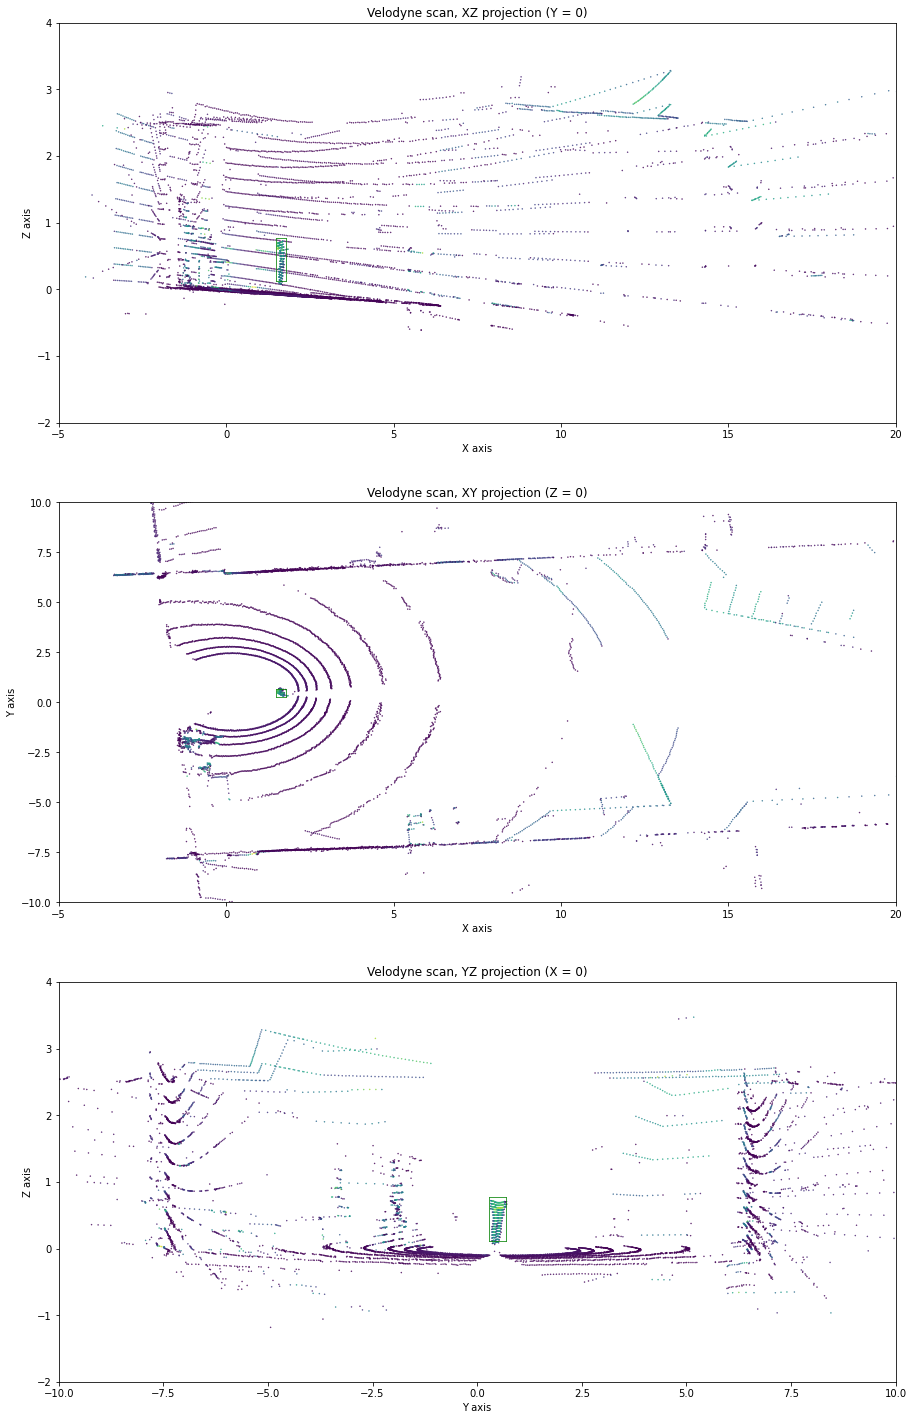

In [64]:
display_frame_statistics(data, gt_box)

## Data Overview

In [28]:
data.shape

(4912377, 6)

In [29]:
data.head()

,rosbagTimestamp,x,y,z,intensity,time
0,1590775583702332952,-1.055055,1.817870,-0.563190,6.0,-0.048886
1,1590775583702332952,-3.424826,5.905756,0.119165,42.0,-0.048884
2,1590775583702332952,-1.224575,2.112502,-0.563727,4.0,-0.048882
3,1590775583702332952,-3.431576,5.924548,0.358815,26.0,-0.048879
4,1590775583702332952,-1.482979,2.562392,-0.575480,1.0,-0.048877


In [43]:
# investigate value ranges
x_max, x_min = np.max(data.x), np.min(data.x)
y_max, y_min = np.max(data.y), np.min(data.y)
z_max, z_min = np.max(data.z), np.min(data.z)
intensity_max, intensity_min = np.max(data.intensity), np.min(data.intensity)

print('x_max: {:.3f}, x_min: {:.3f}'.format(x_max, x_min))
print('y_max: {:.3f} y_min: {:.3f}'.format(y_min, y_max))
print('z_max: {:.3f}, z_min: {:.3f}'.format(z_max, z_min))
print('intensity_max: {:.3f}, intensity_min: {:.3f}'.format(intensity_max, intensity_min))
print('\nNumber of points: {}'.format(data.shape[0]))

x_max: 49.444, x_min: -4.745
y_max: -37.609 y_min: 35.406
z_max: 4.689, z_min: -1.359
intensity_max: 131.000, intensity_min: 0.000

Number of points: 3908367


In [95]:
data.z.mean()

0.46101681533919564

## Backup

### Create PCD Files 

In [30]:
timesteps = data.rosbagTimestamp.unique()
path = bag_dir + '/' + dropdown.value
os.mkdir(path)
thresh = 0 
for i,t in enumerate(timesteps):    
    # Analyze pointcloud from timestamp chosen above 
    oneframe_data = data[data.rosbagTimestamp == t].reset_index(drop=True)
    # Rotate & translate points to compensate for LiDAR tilt angle 
    oneframe_data_trans = df_apply_rot(oneframe_data, quat, return_full_df=True)
    oneframe_data_trans = translate_height(oneframe_data_trans, z_trans)
    # Remove ground points
    oneframe_data_trans_no_floor = remove_ground_points(oneframe_data_trans, thresh)
    # Filter by radius 
    oneframe_data_trans_no_floor = add_polar_coord(oneframe_data_trans_no_floor)
    label_mask = oneframe_data_trans_no_floor.r.between(*interval)
    oneframe_data_trans_no_floor['label'] = label_mask
    # Create template 
    template = oneframe_data_trans_no_floor[oneframe_data_trans_no_floor.label].reset_index(drop=True)
    # Save as binary matrix file for annotation
    temp_frame = template[['x','y','z']].copy()
#     temp = temp_frame.to_numpy(dtype='float32').astype('float32')
    temp = temp_frame.to_numpy()
    p = pcl.PointCloud(np.array(temp, dtype=np.float32))
    p.to_file(path + '/frame_{}_{}.pcd'.format(i,t))
#     temp.tofile(path + '/frame{}.bin'.format(t),  format="%f")

### Visualizations

#### 3D Plot using matplotlib

In [ ]:
%matplotlib notebook

In [ ]:
plot_pointcloud3d(start)

#### 3D Plot using pptk
See documentation [here](https://heremaps.github.io/pptk/index.html). 
Example screenshot of interactive 3D visualzation:
<img src="files/pcl_1585676368204491882.png">

In [113]:
import pptk

In [43]:
v = pptk.viewer(template_no_floor[['x', 'y', 'z']]) 
v.attributes(template_no_floor['intensity'])
v.set(point_size=0.01)

In [ ]:
v.capture('/home/brudermueller/Downloads/pcl_{}.png'.format(str(timesteps[0])))

In [139]:
# take only every 40th timestep
subsample = timesteps[::40]

In [ ]:
pcl = data[data.rosbagTimestamp == timesteps[150]].reset_index()
pcl = df_apply_rot(pcl)
pcl = remove_ground_points(pcl, -0.38)
pcl.head()
pcl = pcl[(pcl.x.between(2.9, 3.5)) & (pcl.y.between(-1, 2))]
v = pptk.viewer(pcl[['x', 'y', 'z']]) 
v.attributes(pcl['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=7)   

In [55]:
# save screenshot of lidar 3D plot for each timestep 
import time
templates = data_trans[data_trans.label].reset_index(drop=True)
# templates = data_trans_no_floor[data_trans_no_floor.label].reset_index(drop=True)

# templates = remove_ground_points(templates, 0)
for i,t in enumerate(timesteps[::10]): 
    pcl = templates[templates.rosbagTimestamp == t].reset_index(drop=True)
    if pcl.empty:
        print t
        continue
    v = pptk.viewer(pcl[['x', 'y', 'z']]) 
    v.attributes(pcl['intensity'])
    v.set(point_size=0.01, lookat=(4.5, -0.5, -1), r=10)    
    time.sleep(2)
#     v.capture('/home/brudermueller/Downloads/med/pcl_templates_{}_{}.png'.format(dropdown.value, i))
#     time.sleep(2)
    v.close()

In [ ]:
v = pptk.viewer(start_ground[['x', 'y', 'z']]) 
v.attributes(start_ground['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)

In [ ]:
v = pptk.viewer(start[['x', 'y', 'z']]) 
v.attributes(start['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)